# Preprocessing and analysis of cfDNA data 

With 2024 Zhou paper used as reference

In [1]:
import pandas as pd
import sys
import subprocess
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyfaidx import Fasta

# import pybedtools
# from pybedtools import BedTool
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


The files used in this notebook are:

<!-- - **bileduct_subsample.bed** - bile duct cancer frag file subsampled to 50k rows (FinaleDB, Crisitano dataset)
- **bileduct_autosomes_chr.bed** - full bile duct cancer frag file
- **openchrom_200bp.bed** - open chromatin regions (DNAseq - E029,E032,E034 and ATACseq reqions for pancancer) merged to a single file, supposed to be around 560k row, but TODO currently at around 800k. Filtered to only use autosomes and with added a 'chr' prefix to the chromosome name column. -->
- **openchrom_with_id.bed** - open chromatin regions with unique ids
<!-- - **fragments_centroids.bed** - fragment file with start and end replaced with centroid coordinates -->
- **frag_centroids_openchrom_intersect.bed** - fragment file with with centroid coordinates intersected with openchrom regions
- **frag_ends_openchrom_intersect.bed** - fragment 5' and 3' ends intersected with openchrom regions - every fragment end which is in a given openchrom region
- **tss_150_50.bed** and **tss_1000_1000.bed** - bed files of flanking regions, created for comparison (as mentioned in the paper)

All sources linked in the protocol.txt file

In [2]:
# TODO poriadok v files

In [3]:
# fragments_path = './data/subsampled/bileduct_subsample.bed'
# fragments_path = './data/fullsample/bileduct_autosomes_chr.bed'
# openchrom_path = './data/processing/openchrom_200bp.bed'
openchrom_path = './data/processing/openchrom_with_id.bed'
original_regions_path = './data/source_data/region.bed'
# fragments_centroids_path = './data/processing/fragments_centroids.bed'
frag_centroids_openchrom_intersect_path = './data/processing/EE87788_frag_centroids_openchrom_intersect.bed'
frag_ends_openchrom_intersect_path = './data/processing/EE87788_frag_ends_openchrom_intersect.bed'
frag_ends_ocf_path = './data/processing/EE87788_frag_ends_ocf.bed'

# tss_150_50_path = './data/processing/tss_150_50.bed'
# tss_1000_1000_path = './data/processing/tss_1000_1000.bed'

#### **Keep df with original region ids to fill regions missing from intersection**

In [4]:
# TODO preco 200bp?

In [5]:
openchrom_with_id = pd.read_csv(
    openchrom_path,
    sep="\t",
    header=None,
    names=["oc_chrom", "oc_start", "oc_end", "region_id"]
)
df_region_ids = openchrom_with_id[['region_id']].drop_duplicates().reset_index(drop=True)
print("Number of unique region IDs:", df_region_ids.shape[0])

Number of unique region IDs: 561414


#### **Load fragments whose centroids fell within openchrom regions:**


In [6]:
frag_centroids_openchrom_intersect = pd.read_csv(
    frag_centroids_openchrom_intersect_path,
    sep="\t",
    header=None,
    names=["f_chrom", "centroid1", "centroid2", "f_start", "f_end", "score", "strand", "oc_chrom", "oc_start", "oc_end", "region_id"]
)
print(frag_centroids_openchrom_intersect.shape)
# frag_centroids_openchrom_intersect.head()
region_id_number = frag_centroids_openchrom_intersect['region_id'].nunique()
print("Number of unique open chromatin regions:", region_id_number)

(1685069, 11)
Number of unique open chromatin regions: 518554


#### **Load fragment ends intersection**

file to be used to compute the features 'end' and 'OCF'

this file contains 1bp bins for each fragment end, and end_type denotes whether its the smaller (U - f_start) or larger (D - f_end) boundary of a fragment


In [7]:
frag_ends_openchrom_intersect = pd.read_csv(
    frag_ends_openchrom_intersect_path,
    sep="\t",
    header=None,
    names=["f_chrom", "end1", "end2", "end_type", "oc_chrom", "oc_start", "oc_end", "region_id"]
)
print(frag_ends_openchrom_intersect.shape)
frag_ends_openchrom_intersect.head()
region_id_number = frag_ends_openchrom_intersect['region_id'].nunique()
print("Number of unique open chromatin regions:", region_id_number)

(3321154, 8)
Number of unique open chromatin regions: 552790


### **original region bed file from authors of the paper**

In [8]:
regions = pd.read_csv(
    original_regions_path,
    sep="\t",
    header=None,
    names=["chrom", "start", "end"]
)
print(regions.shape)
# regions.head()

(561414, 3)


In [9]:
openchrom = pd.read_csv(
    openchrom_path,
    sep="\t",
    header=None,
    names=["chrom", "start", "end", "region_id"]
)
print(openchrom.shape)

(561414, 4)


### LENGTH
2024 Hou et.al. Experimental section:

'For each autosome, fragments shorter than 300 bp were
divided into 30 categories at 10 bp intervals, whereas those longer than
300 bp were grouped into a single category. Consequently, a feature vector
of length 31 × 22 was generated for each sample.'

shape of feature matrix: (22, 31)


/tmp/ipykernel_20598/1432785665.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["f_chrom", "len_bin"])


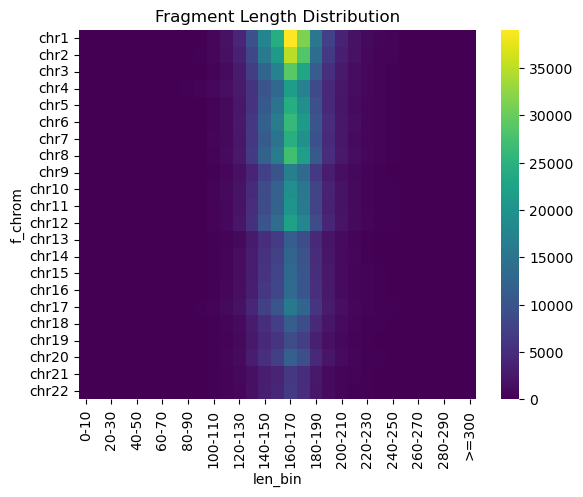

In [10]:
bin_edges = list(range(0, 310, 10)) + [np.inf] 
# print(bin_edges)
bin_labels = [f"{i}-{i+10}" for i in range(0, 300, 10)] + [">=300"]

# fragment lengths
frag_centroids_openchrom_intersect["length"] = frag_centroids_openchrom_intersect["f_end"] - frag_centroids_openchrom_intersect["f_start"]

# bin lengths
frag_centroids_openchrom_intersect["len_bin"] = pd.cut(
    frag_centroids_openchrom_intersect["length"], 
    bins=bin_edges, 
    labels=bin_labels, 
    right=False,
    include_lowest=True
)

# group by chromosome and bin and get counts
length_matrix = (
    frag_centroids_openchrom_intersect
    .groupby(["f_chrom", "len_bin"])
    .size()
    .unstack(fill_value=0)
)

# convert to proportions per chromosome
chrom_order = [f"chr{i}" for i in range(1, 23)]
df_length = length_matrix
df_length = df_length.reindex(chrom_order)

plt.figure()
sns.heatmap(df_length, cmap="viridis")
plt.title("Fragment Length Distribution")
print("shape of feature matrix:", df_length.shape)

    

### **PFE**

'after tallying the selected fragments, they were cat-
egorized as shorter than 100 bp, and longer than 250 bp, and those rang-
ing from 100–250 bp were further divided into 15 categories at 10 bp in-
tervals. Fragment proportions in each category were computed and the
entropy value for that speciﬁc region was calculated using the following
formula'

$
    \text{PFE} = -\sum_iP_i\log_2P_i 
$

where P_i is the raio of fragments in the ith category

 we selected fragments whose centroids fell within the binned openchrom regions. now **iterating over ALL the regions, we calculate PFE using only these selected fragments**.



In [11]:
# # 1 bin below 100bp
# # 15 bins 100-250bp
# # 1 bin above 250bp

bins_pfe = (
    [0, 100] +
    list(range(100, 260, 10)) +
    [np.inf]
)
bins_pfe = sorted(set(bins_pfe))

bin_labels_pfe = [f"{bins_pfe[i]}-{bins_pfe[i+1]}" for i in range(len(bins_pfe)-1)]


# create length column for later binning
frag_centroids_openchrom_intersect["length"] = (
    frag_centroids_openchrom_intersect["f_end"] -
    frag_centroids_openchrom_intersect["f_start"]
)

/tmp/ipykernel_20598/2907993104.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["region_id", "pfe_bin"])


(561414, 1)


,pfe
region_id,
0,1.0
1,-0.0
2,-0.0
3,-0.0
4,1.0


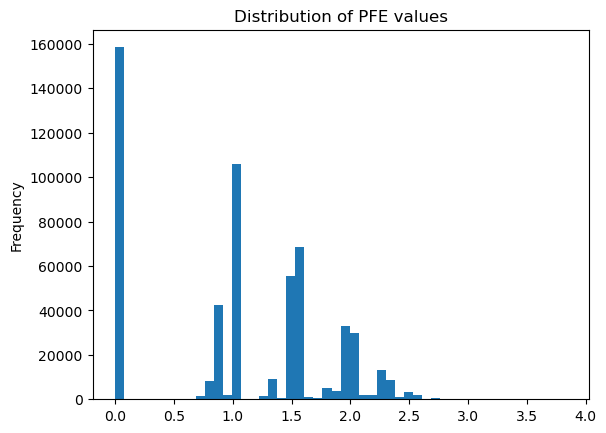

In [12]:
# cut into categories
frag_centroids_openchrom_intersect["pfe_bin"] = pd.cut(
    frag_centroids_openchrom_intersect["length"],
    bins=bins_pfe,
    labels=bin_labels_pfe,
    right=False,
    include_lowest=True
)

# calculate P_i
counts = (
    frag_centroids_openchrom_intersect
    .groupby(["region_id", "pfe_bin"])
    .size()
    .unstack(fill_value=0)
)
pfe_proportions = counts.div(counts.sum(axis=1), axis=0)
pfe_proportions.replace(0, np.nan, inplace=True)

# get actual PFE per refion
pfe = - (pfe_proportions * np.log2(pfe_proportions)).sum(axis=1)
df_pfe = pfe.to_frame("pfe")

# merge pfe result with previously stored region ids to fill blanks
df_pfe = df_region_ids.merge(df_pfe, on="region_id", how="left").set_index('region_id')
df_pfe["pfe"] = df_pfe["pfe"].fillna(0)


# plot distribution
df_pfe['pfe'].plot(kind='hist', bins=50, title='Distribution of PFE values')

print(df_pfe.shape)
df_pfe.head()

### **FSR**

'selected fragments were tallied and divided into
3 categories based on their lengths: short (65–150 bp), medium (151–
220 bp), and long (221–400 bp). The fragment proportion in each category
was calculated and each sample had 561414 × 3 features.'

In [13]:
# i havent confirmed this but i am guessing that 65 is the shortest and 400 is the longest recorded in the dataset, otherwise we would leave out multiple fragments
# 1 bin 65-150bp
# 1 bin 151-220bp
# 1 bin above 221-400bp

bins_fsr = [65, 151, 221, 400]
bin_labels_fsr = [f"{bins_fsr[i]}-{bins_fsr[i+1]}" for i in range(len(bins_fsr)-1)]

frag_centroids_openchrom_intersect["fsr_bin"] = pd.cut(
    frag_centroids_openchrom_intersect["length"],
    bins=bins_fsr,
    labels=bin_labels_fsr,
    right=False,
    include_lowest=True
)
frag_centroids_openchrom_intersect_grouped = frag_centroids_openchrom_intersect.groupby("region_id")

counts = (
    frag_centroids_openchrom_intersect
    .groupby(["region_id", "fsr_bin"])
    .size()
    .unstack(fill_value=0)
)
df_fsr = counts.div(counts.sum(axis=1), axis=0)
df_fsr = df_fsr.merge(df_region_ids, on="region_id", how="right").set_index('region_id')


print(df_fsr.shape)
df_fsr.head()

/tmp/ipykernel_20598/3099475519.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["region_id", "fsr_bin"])


(561414, 3)


,65-151,151-221,221-400
region_id,,,
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.5,0.5,0.0


### **FSD**

"all selected fragments were tallied. Those with
lengths ranging from 65 to 400 bp were divided into 67 categories at 5 bp
intervals, and the fragment proportions in each category were calculated.
Therefore, each sample contained 67 × 22 features"

(22, 67)


/tmp/ipykernel_20598/3368400997.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["f_chrom", "fsd_bin"])


fsd_bin,"[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 95)","[95, 100)","[100, 105)","[105, 110)","[110, 115)","[115, 120)","[120, 125)","[125, 130)","[130, 135)","[135, 140)","[140, 145)","[145, 150)","[150, 155)","[155, 160)","[160, 165)","[165, 170)","[170, 175)","[175, 180)","[180, 185)","[185, 190)","[190, 195)","[195, 200)","[200, 205)","[205, 210)","[210, 215)","[215, 220)","[220, 225)","[225, 230)","[230, 235)","[235, 240)","[240, 245)","[245, 250)","[250, 255)","[255, 260)","[260, 265)","[265, 270)","[270, 275)","[275, 280)","[280, 285)","[285, 290)","[290, 295)","[295, 300)","[300, 305)","[305, 310)","[310, 315)","[315, 320)","[320, 325)","[325, 330)","[330, 335)","[335, 340)","[340, 345)","[345, 350)","[350, 355)","[355, 360)","[360, 365)","[365, 370)","[370, 375)","[375, 380)","[380, 385)","[385, 390)","[390, 395)","[395, 400)"
f_chrom,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
chr1,0.0,0.0,0.000038,0.000196,0.000221,0.000297,0.000486,0.001769,0.002394,0.004909,0.005705,0.013494,0.011706,0.027298,0.032826,0.054167,0.057641,0.070472,0.082564,0.111088,0.135455,0.109976,0.087618,0.056909,0.040401,0.027203,0.019066,0.013772,0.009401,0.006229,0.004612,0.003481,0.002350,0.001965,0.001264,0.001371,0.000929,0.000727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr2,0.0,0.0,0.000063,0.000345,0.000507,0.000619,0.000816,0.002168,0.003048,0.004807,0.006377,0.013746,0.011930,0.026942,0.031947,0.053582,0.058065,0.069904,0.078793,0.110324,0.135655,0.110803,0.089027,0.057284,0.039893,0.026978,0.018806,0.013809,0.009748,0.007214,0.004716,0.003737,0.002344,0.001731,0.001330,0.001098,0.001119,0.000725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr3,0.0,0.0,0.000017,0.000061,0.000035,0.000113,0.000269,0.001678,0.002095,0.004703,0.005668,0.013022,0.011284,0.027557,0.032191,0.053402,0.056358,0.069476,0.080229,0.112229,0.139030,0.110334,0.089122,0.057410,0.041127,0.027870,0.019473,0.013622,0.009076,0.006685,0.004859,0.003269,0.002252,0.001686,0.001339,0.000982,0.000808,0.000669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr4,0.0,0.0,0.000219,0.000765,0.001322,0.001628,0.001705,0.004262,0.005518,0.007540,0.008567,0.014850,0.014391,0.029055,0.034103,0.053750,0.056679,0.066721,0.076446,0.105184,0.131092,0.102845,0.085231,0.055859,0.040059,0.028574,0.020248,0.014806,0.010348,0.008250,0.005999,0.004010,0.002699,0.002295,0.001836,0.001388,0.001125,0.000634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr5,0.0,0.0,0.000010,0.000051,0.000092,0.000082,0.000349,0.001715,0.002249,0.004569,0.005452,0.013071,0.011356,0.025731,0.032898,0.055097,0.056217,0.070848,0.081147,0.111437,0.137169,0.111632,0.088427,0.057367,0.040096,0.027682,0.018821,0.014098,0.009138,0.006900,0.004282,0.003727,0.002475,0.001961,0.001263,0.001171,0.000821,0.000596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


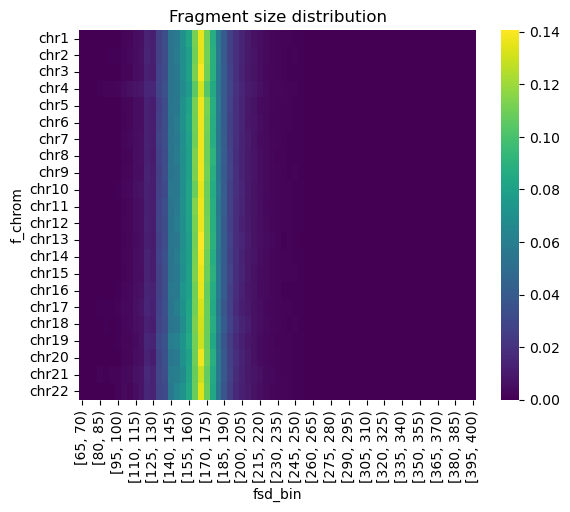

In [14]:
bins_fsd = list(range(65, 405, 5)) 

frag_centroids_openchrom_intersect["fsd_bin"] = pd.cut(
    frag_centroids_openchrom_intersect["length"],
    bins=bins_fsd,
    right=False,
    include_lowest=True
)

counts = (
    frag_centroids_openchrom_intersect
    .groupby(["f_chrom", "fsd_bin"])
    .size()
    .unstack(fill_value=0)
)

df_fsd = counts.div(counts.sum(axis=1), axis=0)
df_fsd = df_fsd.reindex(chrom_order)


print(df_fsd.shape)
display(df_fsd.head()   )
plt.figure()
sns.heatmap(df_fsd, cmap="viridis")
plt.title("Fragment size distribution")
plt.show()


In [15]:
frag_centroids_openchrom_intersect.head()

,f_chrom,centroid1,centroid2,f_start,f_end,score,strand,oc_chrom,oc_start,oc_end,region_id,length,len_bin,pfe_bin,fsr_bin,fsd_bin
0,chr1,10242,10242,10182,10302,4,+,chr1,10194,10394,0,120,120-130,120-130,65-151,"[120, 125)"
1,chr1,10387,10387,10342,10433,0,-,chr1,10194,10394,0,91,90-100,0-100,65-151,"[90, 95)"
2,chr1,17527,17527,17447,17608,40,+,chr1,17388,17588,1,161,160-170,160-170,151-221,"[160, 165)"
3,chr1,96573,96573,96485,96662,27,-,chr1,96514,96714,2,177,170-180,170-180,151-221,"[175, 180)"
4,chr1,103054,103054,102970,103139,20,-,chr1,102859,103059,3,169,160-170,160-170,151-221,"[165, 170)"


### **coverage**

"selected fragments were tallied. For each
sample, the features consisted of a vector of size 561414 × 1 (for subsequent
fragmentation patterns, the number of features for each sample was
561414 × 1 unless otherwise specified)."

(561414, 1)
region with max coverage: 499015


,coverage
region_id,
0,2
1,1
2,1
3,1
4,2


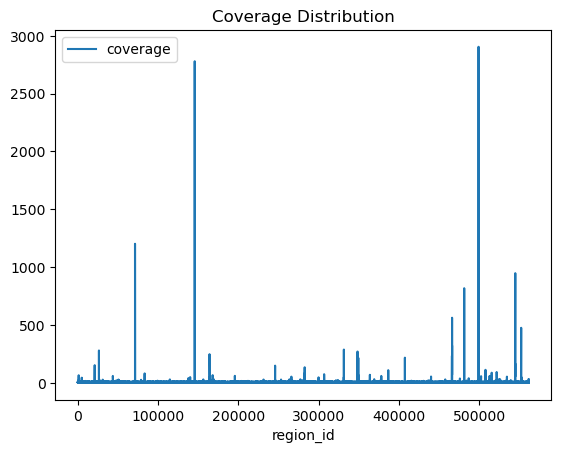

In [16]:
# for coverage we need to merge with the original region id file at the start, since we are just counting occurences
centroids_intersect = df_region_ids.merge(
    frag_centroids_openchrom_intersect,
    on="region_id",
    how="left"
)

# group by regions and count each region
centroids_intersect_grouped = centroids_intersect.groupby("region_id")

df_cov = pd.DataFrame(centroids_intersect_grouped.size())
df_cov = df_cov.rename(columns={0: "coverage"})

# fill the empty regions with 0
df_cov["coverage"] = df_cov["coverage"].fillna(0)
df_cov.plot(kind='line', title='Coverage Distribution')
print(df_cov.shape)
print("region with max coverage:", df_cov['coverage'].idxmax())
display(df_cov.head())


### **end**

"the number of fragment ends within each open
chromatin region was counted."

(561414, 1)
region with max ends: 145609


,end
region_id,
0,23
1,5
2,2
3,5
4,4


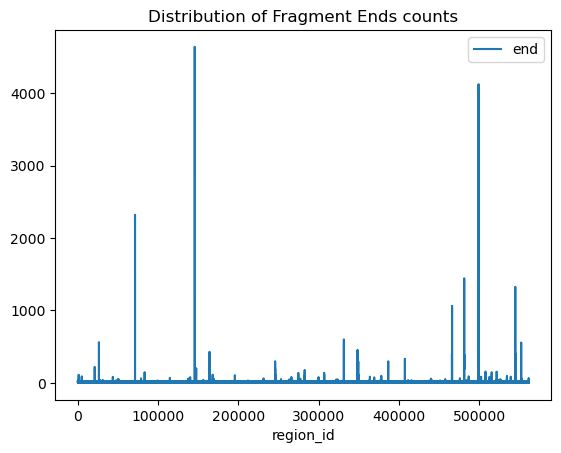

In [17]:
# same as coverage, we merge region ids at the start, in case some regions have no frag ends in them
ends_intersect = df_region_ids.merge(
    frag_ends_openchrom_intersect,
    on="region_id",
    how="left"
)
counts = (
    ends_intersect
    .groupby("region_id")
    .size()
)
df_end = pd.DataFrame(counts).rename(columns={0: "end"})
# plot distribution
df_end.plot(kind='line', title='Distribution of Fragment Ends counts')
print(df_end.shape)
print("region with max ends:", df_end['end'].idxmax())
display(df_end.head())



###  **OCF**

"coordinates of the position with the smaller fragment
genome (U) and that with the larger fragment genome (D) on each
chromosome were determined with the corresponding counts. For each
open chromatin region, a 20 bp range was selected based on a 60 bp shift
upstream and downstream of the centroid. The OCF of the region was
calculated using the following equation:"

$
\mathrm{OCF} = \sum_{-60-10}^{-60+10} (D - U) \;+\; \sum_{60-10}^{60+10} (U - D)
$

In [18]:
# TODO poslat andrejovi mail o vozrci

note:

Sun et al. 2019

'we focused on the nucleosome depletion signal at the center because it was one of the key characteristics (Jiang and Pugh 2009). In such signal, upstream (U) and downstream (D) ends exhibited peaks at ∼60 bp from the center of the open chromatin regions but in different directions (Fig. 3C).Specifically, the D end peak was on the left-hand side, whereas the U end peak was on the right-hand side. We quantified the differences of read densities of the U and D ends in 20-bp windows around the peaks as follows'

In [19]:
frag_ends_ocf = pd.read_csv(
    frag_ends_ocf_path,
    sep="\t",
    header=None,
    names=["chrom", "end1", "end2", "end_type", "oc_start", "oc_end", "region_id", "centroid", "rel_pos"]
)
print(frag_ends_ocf.shape)
display(frag_ends_ocf.head())

(3321158, 9)


,chrom,end1,end2,end_type,oc_start,oc_end,region_id,centroid,rel_pos
0,chr1,10197,10198,D,10194,10394,0,10294,-97
1,chr1,10198,10199,D,10194,10394,0,10294,-96
2,chr1,10245,10246,D,10194,10394,0,10294,-49
3,chr1,10211,10212,D,10194,10394,0,10294,-83
4,chr1,10221,10222,D,10194,10394,0,10294,-73


In [20]:
leftmin, leftmax = -70, -50
rightmin, rightmax = 50, 70
df = frag_ends_ocf
df["window"] = np.where(
    (df["rel_pos"] >= leftmin) & (df["rel_pos"] < leftmax),
    "left",
    np.where(
        (df["rel_pos"] >= rightmin) & (df["rel_pos"] < rightmax),
        "right",
        None
    )
)

df = df[df["window"].notna()]
counts = (
    df
    .groupby(["region_id", "window", "end_type"])
    .size()
    .unstack(fill_value=0)
)
df["window"].value_counts()


window
left     331751
right    330553
Name: count, dtype: int64

In [21]:
counts["left_term"] = (counts["D"] - counts["U"])
counts["right_term"] = (counts["U"] - counts["D"])

ocf = (
    counts
    .groupby("region_id")[["left_term", "right_term"]]
    .sum()
    .sum(axis=1)
)
print(ocf.shape)
df_ocf = (
    df_region_ids
    .merge(ocf.rename("ocf"), on="region_id", how="left")
    .fillna(0)
)
df_ocf.set_index('region_id', inplace=True)
print(df_ocf.shape)
counts[["U", "D"]].describe()
df_ocf.head()


(371456,)
(561414, 1)


,ocf
region_id,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


### IFS

"the fragments (n) within each open chromatin region including
the fragment centroid were counted and their average length (l)
within the region was calculated. L represents the average fragment length
of the whole chromosome. The calculation formula is as follows:"

$
IFS = n * ( 1 + \frac{l}{L} )
$

In [22]:
# count fragments (n), calculate average lengths (l),
region_counts = frag_centroids_openchrom_intersect.groupby("region_id").size()
region_avg_length = frag_centroids_openchrom_intersect.groupby("region_id")["length"].mean()

# average length per chromosome (L):
chrom_avg_length = frag_centroids_openchrom_intersect.groupby("f_chrom")["length"].mean()

# add chrom avg to main df
frag_centroids_openchrom_intersect["chrom_avg"] = frag_centroids_openchrom_intersect["f_chrom"].map(chrom_avg_length)

(561414, 1)


,IFS
count,561414.000000
mean,6.002946
std,15.042136
min,0.000000
25%,3.682278
50%,5.841561
75%,8.070925
max,5784.283278


,IFS
region_id,
0,3.281703
1,1.977982
2,2.075172
3,2.026577
4,4.095675


<Axes: title={'center': 'Distribution of IFS values'}, xlabel='region_id'>

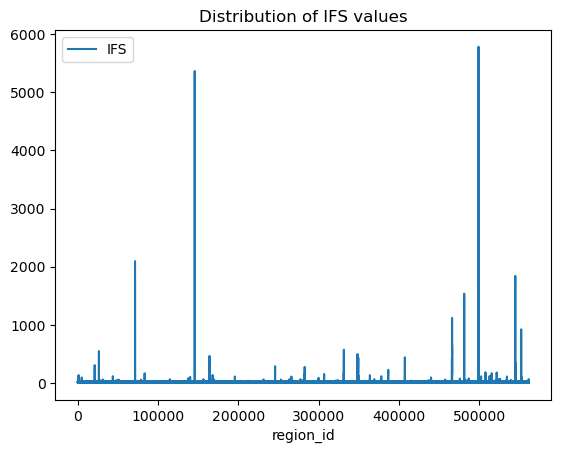

In [23]:
df_ifs = pd.DataFrame({
    "region_id": region_counts.index,
    "n": region_counts.values,
    "l": region_avg_length.values
})

# map chromosome for L
region_chrom = frag_centroids_openchrom_intersect.groupby("region_id")["f_chrom"].first()
df_ifs["chrom"] = df_ifs["region_id"].map(region_chrom)
df_ifs["L"] = df_ifs["chrom"].map(chrom_avg_length)

# compute IFS and fill the missing regions
df_ifs["IFS"] = df_ifs["n"] * (1 + df_ifs["l"] / df_ifs["L"])
df_ifs = df_region_ids.merge(df_ifs[["region_id", "IFS"]], on="region_id", how="left").fillna(0)
df_ifs.set_index('region_id', inplace=True)
print(df_ifs.shape)
display(df_ifs.describe())
display(df_ifs.head())
df_ifs.plot(kind='line', title='Distribution of IFS values')

### WPS

"according to the genomic coordinate position of each
cfDNA fragment, a window of 120 bp was slid at 1 bp intervals, and the
likelihood of each base pair being covered at the whole genome level, fully
covered (+1), and partially covered (−1), was counted. The mean value of
all loci within each open chromatin region was calculated."

- count_of_fully_covered (F) - count_of_partially_covered (P)
- take the mean of these values for all positions (N - length of genome)

$$
WPS = \frac{1}{N} \sum_{i=1}^{N} (\text{F}_i - \text{P}_i)
$$

- for computation speed sake we iterate over fragments rather than genome positions, since positions which dont overlap are ignored

In [24]:
#TODO

### EDM

"the EDM consisting of 4 bases at the 5′ end of the cfDNA
fragment whose fragment centroid was within the open chromatin region
was viewed. The proportion of each EDM on each chromosome was
counted separately. Therefore, for each sample, the feature had a vector of
size 256 × 22."

In [25]:
hg19 = Fasta('./data/source_data/hg19.fa')

In [26]:
# # 5'ends
# ends_5 = frag_centroids_openchrom_intersect[['f_chrom','f_start','region_id']].copy()
# ends_5['pos'] = ends_5['f_start']
# ends_5['end_type'] = '5'

# # 3' ends
# ends_3 = frag_centroids_openchrom_intersect[['f_chrom','f_end','region_id']].copy()
# ends_3['pos'] = ends_3['f_end'] - 4
# ends_3['end_type'] = '3'

# ends = pd.concat([ends_5, ends_3], ignore_index=True)

# def get_motif(df, genome, k=4):
#     chrom = df.name
#     seq = genome[chrom]
#     motifs = [
#         str(seq[pos:pos+k].seq).upper()
#         if pos >= 0 else None
#         for pos in df['pos'].values
#     ]
#     return pd.Series(motifs, index=df.index)

# ends['motif'] = (
#     ends
#     .groupby('f_chrom', group_keys=False)
#     .apply(get_motif, genome=hg19, k=4)
# )

In [27]:
# # filter out non-acgt letters (N)
# ends.loc[~ends['motif'].str.match('^[ACGT]{4}$'), 'motif'].head()
# ends = ends[ends['motif'].str.match('^[ACGT]{4}$')]

# # # now we calculate proportions of each motif at each end per chromosome - 256x22
# motif_counts = (
#     ends
#     .groupby(['f_chrom', 'motif'])
#     .size()
#     .unstack(fill_value=0)
# )
# df_motif = motif_counts.div(motif_counts.sum(axis=1), axis=0)
# df_motif = df_motif.reindex(chrom_order)
# print(df_motif.shape)
# print("motif with max proportion:", df_motif.max().idxmax())
# display(df_motif.head())
# sns.heatmap(df_motif, cmap="viridis")


In [28]:
# TODO pochatovat o multidimensional datach
# metadata 